# **Big Mark Sales Prediction**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import xgboost as xgb

%matplotlib inline

In [2]:
big_mart_data = pd.read_csv('data/Train.csv')
big_mart_data.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350


In [3]:
big_mart_data.shape

(8523, 12)

In [4]:
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Categorical Features:
- Item_Identifier
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Size
- Outlet_Location_Type
- Outlet_Type

In [5]:
big_mart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [6]:
big_mart_data.fillna({'Item_Weight': big_mart_data['Item_Weight'].mean()}, inplace=True)

In [7]:
mode_of_Outlet_size = big_mart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [8]:
print(mode_of_Outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [9]:
miss_values = big_mart_data['Outlet_Size'].isnull()

In [10]:
big_mart_data.loc[miss_values, 'Outlet_Size'] = big_mart_data.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [11]:
big_mart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [12]:
big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


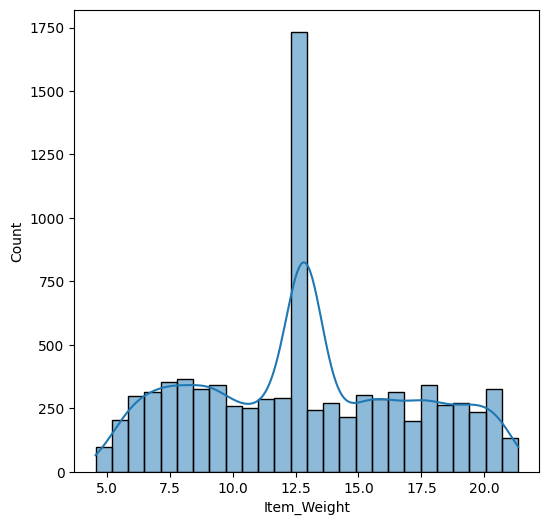

In [13]:
plt.figure(figsize=(6,6))
sns.histplot(big_mart_data['Item_Weight'], kde=True)
plt.show()

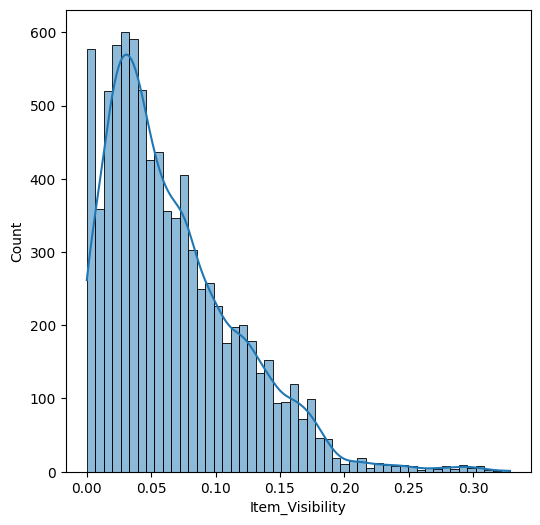

In [14]:
plt.figure(figsize=(6,6))
sns.histplot(big_mart_data['Item_Visibility'], kde=True)
plt.show()

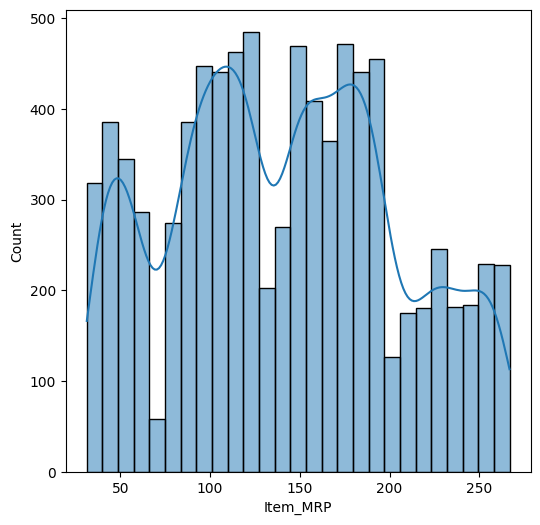

In [15]:
plt.figure(figsize=(6,6))
sns.histplot(big_mart_data['Item_MRP'], kde=True)
plt.show()

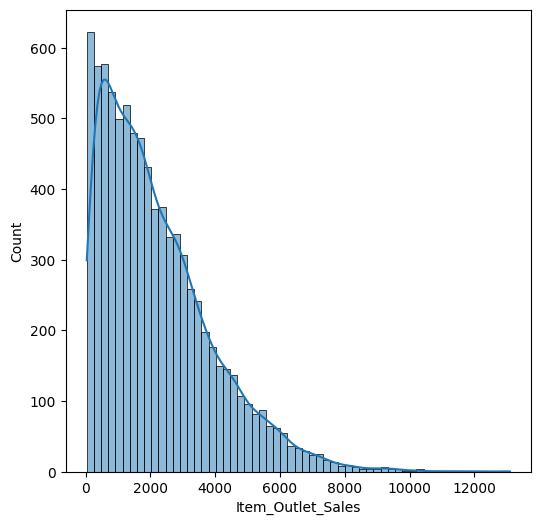

In [16]:
plt.figure(figsize=(6,6))
sns.histplot(big_mart_data['Item_Outlet_Sales'], kde=True)
plt.show()

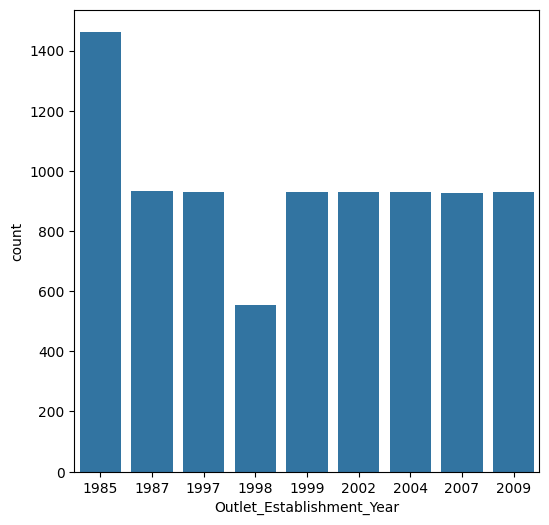

In [17]:
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data=big_mart_data)
plt.show()

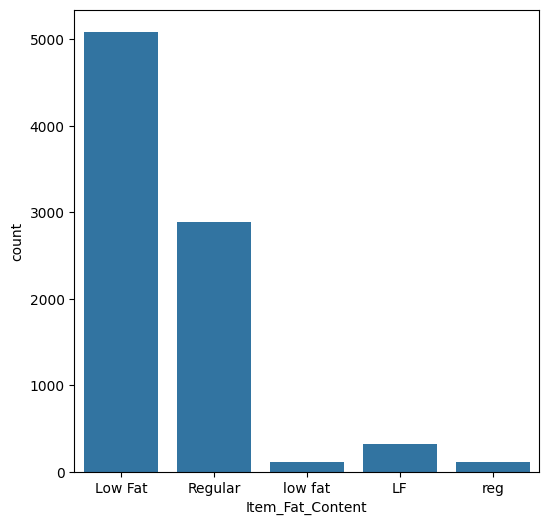

In [18]:
plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content', data=big_mart_data)
plt.show()

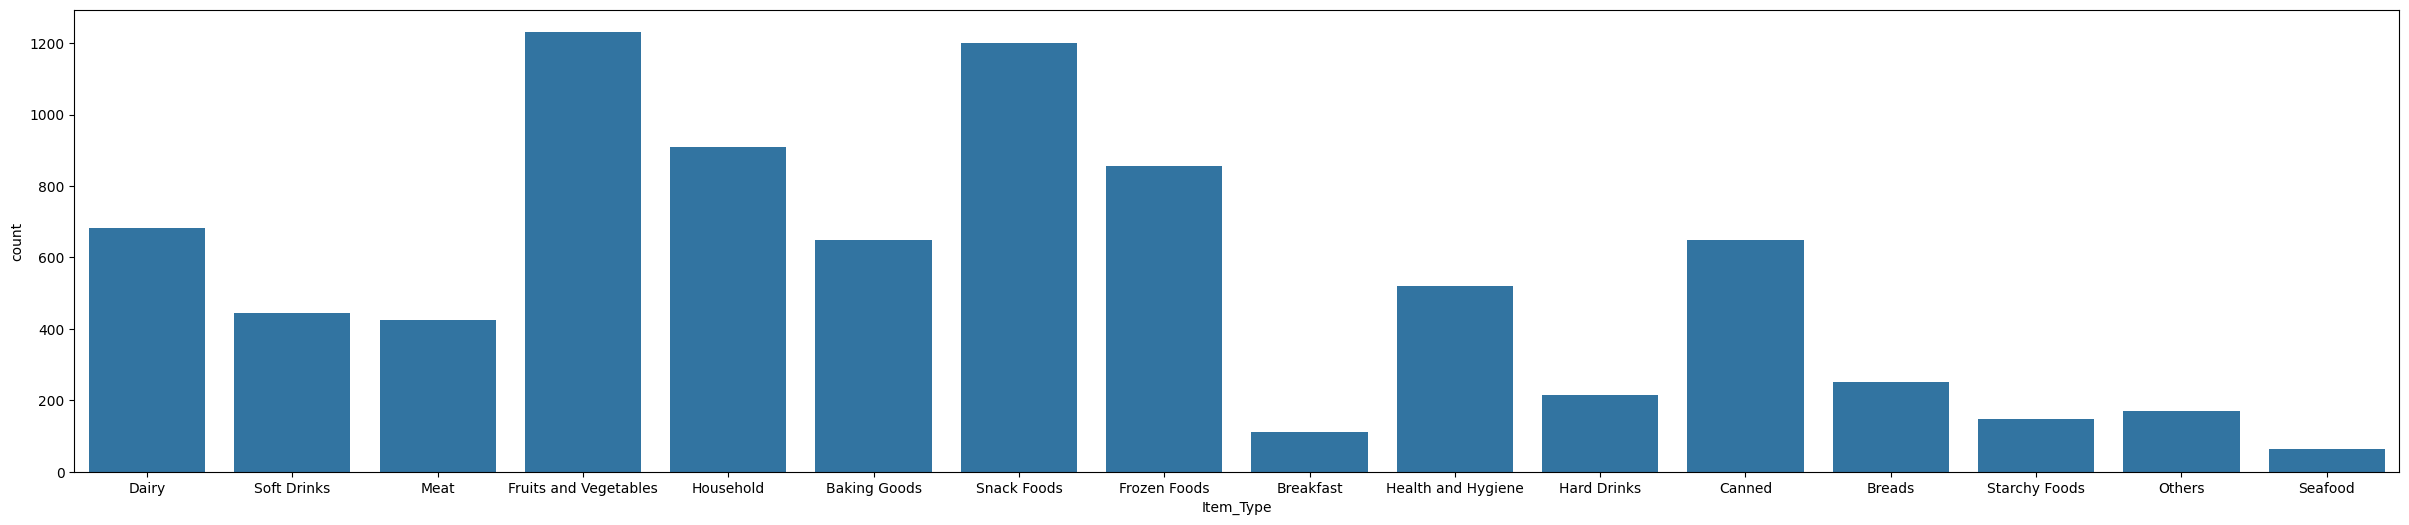

In [19]:
plt.figure(figsize=(30,6))
sns.countplot(x='Item_Type', data=big_mart_data)
plt.show()

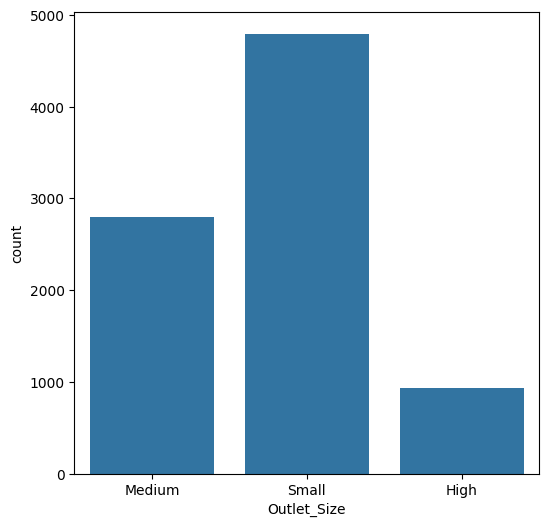

In [20]:
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Size', data=big_mart_data)
plt.show()

In [21]:
big_mart_data['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

In [22]:
big_mart_data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)
big_mart_data['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

In [23]:
big_mart_data['Item_Identifier'] = LabelEncoder().fit_transform(big_mart_data['Item_Identifier'])
big_mart_data['Item_Fat_Content'] = LabelEncoder().fit_transform(big_mart_data['Item_Fat_Content'])
big_mart_data['Item_Type'] = LabelEncoder().fit_transform(big_mart_data['Item_Type'])
big_mart_data['Outlet_Identifier'] = LabelEncoder().fit_transform(big_mart_data['Outlet_Identifier'])
big_mart_data['Outlet_Size'] = LabelEncoder().fit_transform(big_mart_data['Outlet_Size'])
big_mart_data['Outlet_Location_Type'] = LabelEncoder().fit_transform(big_mart_data['Outlet_Location_Type'])
big_mart_data['Outlet_Type'] = LabelEncoder().fit_transform(big_mart_data['Outlet_Type'])

big_mart_data.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.300000,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.920000,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.500000,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.200000,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.930000,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052
5,758,10.395000,1,0.000000,0,51.4008,3,2009,1,2,2,556.6088
6,696,13.650000,1,0.012741,13,57.6588,1,1987,0,2,1,343.5528
7,738,12.857645,0,0.127470,13,107.7622,5,1985,1,2,3,4022.7636
8,440,16.200000,1,0.016687,5,96.9726,7,2002,2,1,1,1076.5986
9,990,19.200000,1,0.094450,5,187.8214,2,2007,2,1,1,4710.5350


In [24]:
X = big_mart_data.drop(columns='Item_Outlet_Sales', axis=1)
X = StandardScaler().fit_transform(X)
y = big_mart_data['Item_Outlet_Sales']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

### **Linear Regression**

In [25]:
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

lr_model = LinearRegression()
lr_model_cv = GridSearchCV(lr_model, param_grid, cv=3, n_jobs=-1 , scoring='r2')
lr_model_cv.fit(X_train, y_train)
y_pred_lr = lr_model_cv.predict(X_test)

res = r2_score(y_test, y_pred_lr)
print(res)

score = cross_val_score(lr_model, X, y, cv=5, scoring='r2')
print('Cross Val score ', score, score.mean(), score.std())
print('Best Params to use ', lr_model_cv.best_params_)
print("Mean Absolute error: %f" % mean_absolute_error(y_test, y_pred_lr))
print("Root Mean Squared error: %f" % root_mean_squared_error(y_test, y_pred_lr))

0.520159740836995
Cross Val score  [0.51819979 0.5040836  0.48307066 0.50208964 0.49990968] 0.5014706742880868 0.01120777291663332
Best Params to use  {'copy_X': True, 'fit_intercept': True, 'positive': False}
Mean Absolute error: 855.580681
Root Mean Squared error: 1142.012023


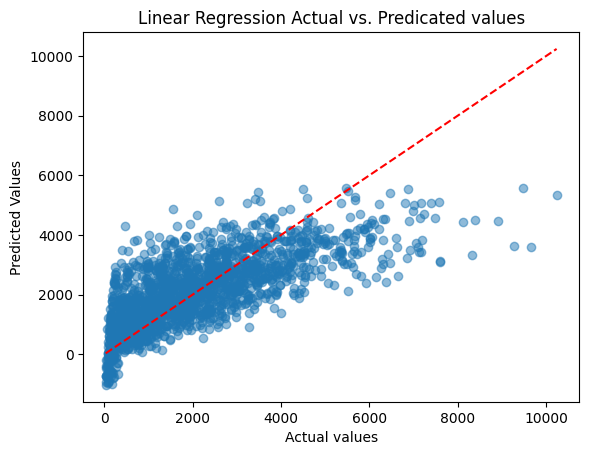

In [26]:
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', linestyle="--")
plt.xlabel('Actual values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression Actual vs. Predicated values')
plt.show()

### **Decision Tree Regression**

In [27]:
param_grid_dt = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

dt_model = DecisionTreeRegressor(random_state=0)
grid_search_dt = GridSearchCV(dt_model, param_grid_dt, cv=3, n_jobs=-1, scoring='r2')
grid_search_dt.fit(X_train, y_train)
y_pred_dt = grid_search_dt.predict(X_test)

res_dt = r2_score(y_test, y_pred_dt)
print(res_dt)
score = cross_val_score(dt_model, X, y, cv=5, scoring='r2')
print('Cross Val score ', score, score.mean(), score.std())
print('Best Params to use ', grid_search_dt.best_params_)
print("Mean Absolute error: %f" % mean_absolute_error(y_test, y_pred_dt))
print("Root Mean Squared error: %f" % root_mean_squared_error(y_test, y_pred_dt))

0.5570362248298756
Cross Val score  [0.18453093 0.12596655 0.10001053 0.15787721 0.20986252] 0.15564954913251638 0.03938254609835668
Best Params to use  {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Mean Absolute error: 764.428675
Root Mean Squared error: 1097.252150


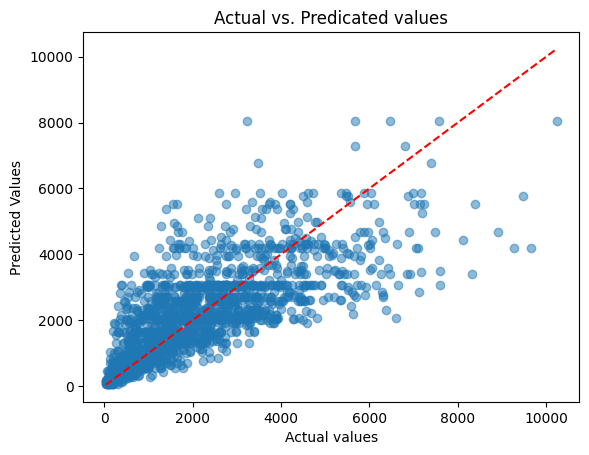

In [28]:
plt.scatter(y_test, y_pred_dt, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', linestyle="--")
plt.xlabel('Actual values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicated values')
plt.show()

### **Random Forest Regression**

In [29]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [20,30,40],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}

rf_model = RandomForestRegressor()
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=3, n_jobs=-1, scoring='r2')
grid_search_rf.fit(X_train, y_train)
y_pred_rf = grid_search_rf.predict(X_test)

res = r2_score(y_test, y_pred_rf)
print(res)

score = cross_val_score(dt_model, X, y, cv=5, scoring='r2')
print('Cross Val score ', score, score.mean(), score.std())
print('Best Params to use ', grid_search_rf.best_params_)
print("Mean Absolute error: %f" % mean_absolute_error(y_test, y_pred_rf))
print("Root Mean Squared error: %f" % root_mean_squared_error(y_test, y_pred_rf))

0.5857824983008433
Cross Val score  [0.18453093 0.12596655 0.10001053 0.15787721 0.20986252] 0.15564954913251638 0.03938254609835668
Best Params to use  {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Mean Absolute error: 741.246552
Root Mean Squared error: 1061.051729


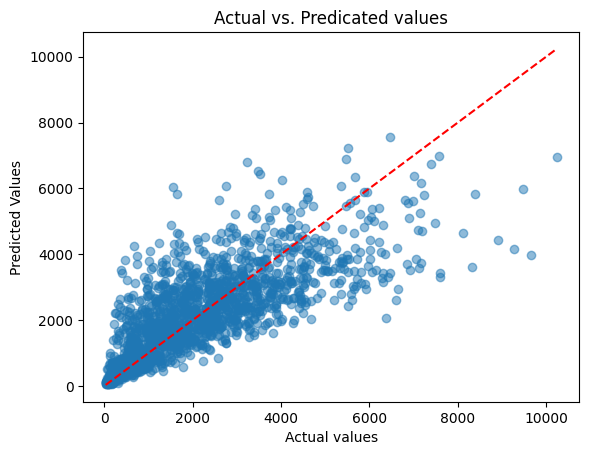

In [30]:
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', linestyle="--")
plt.xlabel('Actual values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicated values')
plt.show()

### **XGBOOST**

In [31]:
param_grid = {
    'n_estimators': [300,400,500],
    'max_depth': [5,6,7],
    'learning_rate': [0.01,0.1,0.2],
    'subsample': [0.6, 0.8, 1.0], 
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

xgb_model = xgb.XGBRegressor()
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='r2')
grid_search_xgb.fit(X_train, y_train)
y_pred_xgb = grid_search_xgb.predict(X_test)

res = r2_score(y_test, y_pred_xgb)
print(res)

score = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')
print('Cross Val score ', score, score.mean(), score.std())
print('Best Params to use ', grid_search_xgb.best_params_)
print("Mean Absolute error: %f" % mean_absolute_error(y_test, y_pred_xgb))
print("Root Mean Squared error: %f" % root_mean_squared_error(y_test, y_pred_xgb))

0.6101746796160468
Cross Val score  [0.52485506 0.4933265  0.47775672 0.49501617 0.50570057] 0.4993310037995875 0.015570293932531013
Best Params to use  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}
Mean Absolute error: 724.613264
Root Mean Squared error: 1029.336462


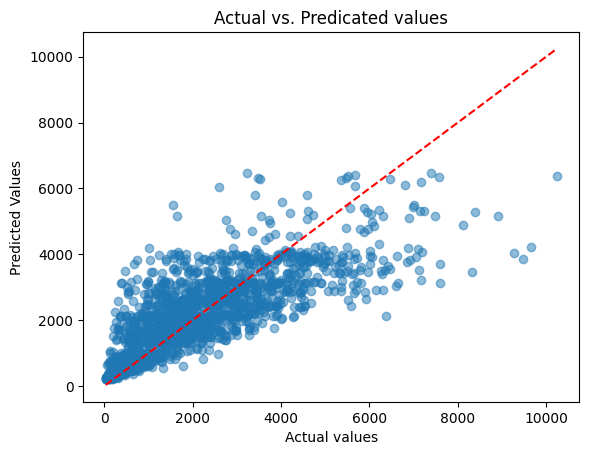

In [32]:
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', linestyle="--")
plt.xlabel('Actual values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicated values')
plt.show()